In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle

In [2]:
# load the  data
with open('../data/user2movie.pkl', 'rb') as f:
  user2movie = pickle.load(f)
with open('../data/movie2user.pkl', 'rb') as f:
  movie2user = pickle.load(f)
with open('../data/usermovie2rating.pkl', 'rb') as f:
  usermovie2rating = pickle.load(f)
with open('../data/user2movie_test.pkl', 'rb') as f:
  user2movie_test = pickle.load(f)
with open('../data/movie2user_test.pkl', 'rb') as f:
  movie2user_test = pickle.load(f)
with open('../data/usermovie2rating_test.pkl', 'rb') as f:
  usermovie2rating_test = pickle.load(f)

In [3]:
num_users = len(set(user2movie))
num_movies = len(set(movie2user.keys()))
print(num_movies , num_users)

1000 1000


In [4]:
# initialise values
k = 10 # latent dimensionality
w = np.random.randn(num_users, k)
b = np.zeros(num_users)
u = np.random.randn(num_movies, k)
c = np.zeros(num_movies)
mu = np.mean(list(usermovie2rating.values()))
reg =20. # regularization penalty

In [5]:
def calc_r_ij(w_i, u_j, b_i,  c_j , mu):
    return w_i.dot(u_j) + b_i + c_j + mu

In [6]:
def create_predictions(um2r , w , u , b , c , mu):
    pred_dict = {}
    for i , rating in usermovie2rating.items():
        user , movie = i
        r_ij_hat = calc_r_ij(w[user] , u[movie] , b[user] , c[movie] , mu)
        pred_dict[i] = r_ij_hat
    return pred_dict

In [7]:
def update_wb(reg , k , num_users , w , u , b , c , mu , um2r , u2m):
    for user in range(num_users):
        movies_list = u2m[user]
        my_vector = np.zeros(k)
        b_user = 0
        my_matrix = np.eye(k) * reg
        for movie in movies_list:
            r = um2r[(user , movie)]
            my_vector += (r - b[user] - c[movie] - mu) * u[movie]
            my_matrix += np.outer(u[movie] , u[movie])
        
            b_user += (r - w[user].dot(u[movie]) - c[movie] - mu)
        
        w[user] = np.linalg.solve(my_matrix , my_vector)
        b[user] = b_user / (len(movies_list) + reg) 
    return w , b

In [8]:
def update_uc(reg , k , num_movies , w , u , b , c , mu , um2r , m2u):
    for movie in range(num_movies):
        c_movie = 0
        my_matrix = np.eye(k) * reg
        my_vector = np.zeros(k)
        user_list = m2u[movie]
        for user in user_list:
            r = um2r[(user , movie)]
            my_vector += (r - b[user] - c[movie] - mu) * w[user]
            my_matrix += np.outer(w[user] , w[user])
            c_movie += (r - w[user].dot(u[movie])  - b[user] - mu)
        u[movie] = np.linalg.solve(my_matrix , my_vector)
        c[movie] = c_movie/ (len(user_list) + reg)
    return u , c

In [9]:
# mse as metric for performance
def loss(d, w , u , b , c , mu): # user to movie matrix
    # d: (user_id, movie_id) -> rating
    len_dict = float(len(d))
    sse = 0
    for key, rating in d.items():
        user, movie = key
        pred = w[user].dot(u[movie]) + b[user] + c[movie] + mu
        sse += (pred - rating)**2
    return sse / len_dict

In [10]:
#use lambda for norm as its quicker to write
norm = lambda x: np.linalg.norm(x)**2

def reg_loss(d , w , u , b , c , mu ,reg):
    my_loss = loss(d , w , u , b ,c , mu)
    reg_loss = my_loss + (reg * (norm(w) + norm(u) + norm(b) + norm(c)))
    return my_loss , reg_loss

In [11]:
train_losses = []
train_reg_losses = []

# test data
test_losses = []
test_reg_losses = []

In [12]:
%%time
epochs = 25
for epoch in range(epochs):
    w , b = update_wb(reg , k , num_users , w , u , b , c , mu , usermovie2rating , user2movie)
    u , c = update_uc(reg , k , num_movies , w , u , b , c , mu , usermovie2rating , movie2user)
    # pred_dict = create_predictions(usermovie2rating , w , u , b , c , mu)
    train_loss, train_reg_loss = reg_loss(usermovie2rating , w , u , b , c , mu , reg)
    
    train_reg_losses.append(train_reg_loss)
    train_losses.append(train_loss)
    
    test_loss , test_reg_loss = reg_loss(usermovie2rating_test , w , u , b , c , mu , reg)
    
    test_losses.append(test_loss)
    test_reg_losses.append(test_reg_loss)

CPU times: user 5min 10s, sys: 4.92 s, total: 5min 15s
Wall time: 5min 9s


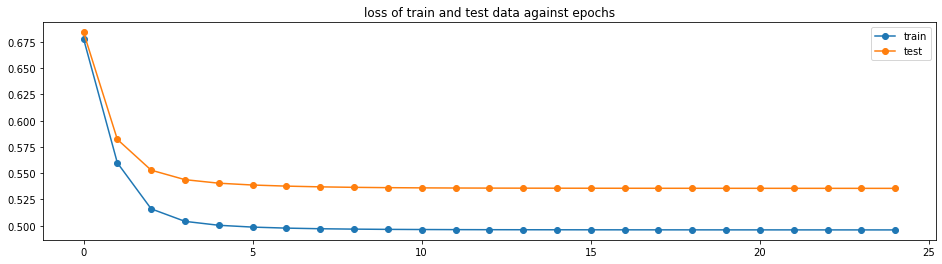

In [14]:
plt.figure(figsize=(16, 4))
plt.title('loss of train and test data against epochs')
plt.plot(train_losses , marker = 'o' , label = 'train')
plt.plot(test_losses , marker = 'o' , label = 'test')
plt.legend()
plt.show()

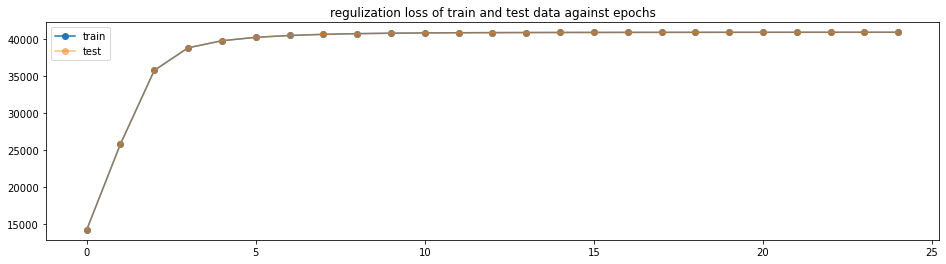

In [15]:
#l2 regulization is supposed to increase with number of epochs
plt.figure(figsize = (16 , 4))
plt.title('regulization loss of train and test data against epochs')
plt.plot(train_reg_losses , marker = 'o', label = 'train')
plt.plot(test_reg_losses , marker = 'o', label = 'test' , alpha = 0.5)
plt.legend()
plt.show()